# Laboratorio 2 
    Autores: Raúl Jiménez Juárez 
             Beatriz Magán Pinto 
             Andrés Felipe Sánchez Patarroyo
             David Alonso Rodríguez-Lepina      
    Asignatura: Aprendizaje Estadístico & Data Mining 
    Fecha: 10/10/2019 

## Importamos las librerías necesarias. 

In [1]:
import mlxtend
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from numpy import genfromtxt 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx

## Transformación de los datos en formato válido

Para utilizar la función del algoritmo apriori, contenida dentro de la librería de mlxtend, se debe utilizar un formato de dataframe en el cual las columnas representan los posibles items del ticket, las filas representan los tickets (o transacciones) y en cada celda se encuentra un booleano que indica si el item está en el ticket o no.

In [2]:
def encoder(transactions):
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    return pd.DataFrame(te_ary, columns=te.columns_)

## Definimos una función para obtener el soporte de un item en particular (para k=1)
Hacemos uso de la función apriori de la libreria mlxtend, para poder encontrar cualquiera de los items individuales, establecemos el soporte mínimo en 0 y una longitud máxima de 1 (sólo hay un item en cada itemset).

In [3]:
def get_support_k1(df,itemset):
    itset=set(itemset)
    items_frecuentes = apriori(df, min_support=0,max_len=1, use_colnames=True)
    return items_frecuentes.loc[items_frecuentes['itemsets']==itset]['support'].values[0]

## Definimos una función para obtener todos los items individuales (k=1) con su respectivo soporte
Al igual que en la función anterior, definimos un soporte mínimo de 0 y una longitud máxima de 1.

In [4]:
def get_all_k1_itemsets(df):
    return apriori(df, min_support=0,max_len=1, use_colnames=True)

## Definimos una función para obtener los items frecuentes en itemsets con k items
Para esta función se tiene en cuenta el orden (k) asi como un soporte mínimo, la función genera los itemsets frecuentes (mayores al soporte minimo) con k elementos.

In [5]:
def get_k_th_frecuent_itemsets(df,support,k):
    items_frecuentes = apriori(df, min_support=support, use_colnames=True)
    items_frecuentes['length'] = items_frecuentes['itemsets'].apply(lambda x: len(x))
    return items_frecuentes[ (items_frecuentes['length'] == k)]


## Definimos una función para obtener todos los itemsets frecuentes
Esta funcion devuelve todos los itemsets cuyo soporte es mayor al minimo establecido, a partir del dataframe que este genera, se elaborarán las reglas de asociación.

In [6]:
def get_freq_itemsets(df,support):
    f_i= apriori(df, min_support=support, use_colnames=True)
    f_i['length'] = f_i['itemsets'].apply(lambda x: len(x))
    return f_i

## Definimos una función para obtener las reglas de asociación
En este caso, a partir de una confianza mínima (valores entre 0 y 1).

In [7]:
def a_rules_by_confidence(df_fi,confidence):
    reglas_asociacion = association_rules(df_fi, metric="confidence", min_threshold=confidence)
    reglas_asociacion.drop(['lift','leverage','conviction'], 1, inplace=True)
    reglas_asociacion['order'] =reglas_asociacion['antecedents'].apply(lambda x: len(x))+reglas_asociacion['consequents'].apply(lambda x: len(x))
    return reglas_asociacion


## Definimos una función para obtener las reglas de asociación
En este caso, a partir de un item antecesor el cual puede estar solo o dentro de un itemset con varios elementos.

In [8]:
def contains_antecessor(df,antecesor_list):
    antecesor=set(antecesor_list)
    return df[df.antecedents >= antecesor].copy()


### Función de desplazamiento de mapa de color
Esta función es utilizada por el método de representación gráfica 1 para obtener mejores colores para los enlaces entre nodos.

In [9]:
def despColorMap(cmap, ini=0, med=0.5, fin=1.0, nombre='shiftedcmap'):

    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(ini, fin, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, med, 128, endpoint=False), 
        np.linspace(med, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(nombre, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

## Método de representación gráfica 1
Ilustración de las reglas de asociación mediante nodos y enlaces, se definen dos tipos de nodos, los items (en fondo blanco) y las reglas (en fondo gris), los enlaces son dirigidos para representar cuales son antecesores (apuntan a la regla y tienen tonos azules) o sucesores (salen desde la regla y tienen tonos verdes), la intensidad de los colores representa que tan confiable es esa regla en relación con las demás en el gráfico, una regla con una confianza considerable frente a las demás, tendra tonos oscuros, mientras una regla con baja confianza o un conjunto de reglas con confianza similar tendrá tonos mas claros.

In [10]:
def plot_rules_no1(rules):
    orig_B = plt.cm.Blues
    shifted_B = despColorMap(orig_B, ini=0.35, med=0.6, fin=0.95, nombre='shifted_b')
    orig_G = plt.cm.Greens
    shifted_G = despColorMap(orig_G,ini=0.35, med=0.6, fin=0.95, nombre='shifted_G')
    set1=set([])
    edges_from=[]
    conf1=[]
    edges_to=[]
    conf2=[]
    nodes_r=[]
    for index, row in rules.iterrows():
        set1=set1.union(row.antecedents,row.consequents)
        n_rule='r '+str(index)
        nodes_r.append(n_rule)
        for ant in list(row.antecedents):
            edges_from.append((ant,n_rule))
            conf1.append(row.confidence)
        for con in list(row.consequents):
            edges_to.append((n_rule,con))
            conf2.append(row.confidence)
    nodes_i=list(set1)
    G=nx.DiGraph()
    G.add_nodes_from(nodes_r)
    G.add_nodes_from(nodes_i)
    G.add_edges_from(edges_from)
    G.add_edges_from(edges_to)
    pos = nx.shell_layout(G, center=[0,1],nlist=[nodes_i,nodes_r])  # positions for all nodes
    # nodes
    plt.figure(figsize=(10,10))
    #nx.draw_circular(G, with_labels=True, node_size=1500, node_color="skyblue")
    #nx.draw_networkx_nodes(G, pos,node_size=1500)
    
    #Pintamos los nodos
    nx.draw_networkx_nodes(G, pos,
                        nodelist=nodes_i,
                        node_color='white',
                        node_size=1500,
                        alpha=0.7)
    nx.draw_networkx_nodes(G, pos,
                        nodelist=nodes_r,
                        node_color="#828282",
                        node_size=1500,
                        alpha=0.8)
    # edges
    #nx.draw_networkx_edges(G, pos, width=1.0, style ='dotted',alpha=1,arrows =True)
    
    #Pitamos las aristas
    nx.draw_networkx_edges(G, pos,
                           edgelist=edges_from,
                           width=2.5, alpha=0.7, edge_color=np.around(conf1, decimals=2),edge_cmap=shifted_B,arrows =True, label='Antecedentes')
    nx.draw_networkx_edges(G, pos,
                          edgelist=edges_to,
                          width=2.5, alpha=0.7, edge_color=np.around(conf2, decimals=2),edge_cmap=shifted_G,arrows =True, label='Consecuentes')


    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.axis('off')
    plt.show()


## Metodo de representación grafica 2
Se analizarán 3 factores de las reglas de asociación:
<ol>
    <li>Confianza de la regla</li>
    <li>Soporte del itemset del que surgue la regla</li>
    <li>Orden de la regla (cuantos elementos estan en antesecores y sucesores)</li>
</ol>
El soporte y la confianza se representan a través de los ejes x e y respectivamente, el orden de la regla se representa mediante el color, las tonalidades más oscuras indican ordenes mas altos.

In [11]:
def plot_rules_no2(rules):
    max_order=rules.max()['order']
    print(max_order)
    groups = rules.groupby('order')
    # Plot
    fig, ax = plt.subplots()
    ax.margins(0.1) # Optional, just adds 5% padding to the autoscaling
    for order, group in groups:
        ax.plot(group.support, group.confidence, marker='.',markeredgewidth=0, linestyle='',c=[1,1- order/max_order, 1- order/max_order,order/max_order], ms=12, label='orden '+str(order))
    ax.legend()
    plt.title('reglas clasificadas por orden')
    plt.xlabel('soporte')
    plt.ylabel('confianza')
    plt.show()

## Representación grafica 2 de resumen
Esta representación permite realizar comparaciones entre las 3 configuraciones de soporte, para analizar el comportamiento de las reglas dado un soporte minimo diferente (aunque puede ser usada igualmente para comparar los cambios de confianza mínima).

In [12]:
def plot_rules_no2_3(df1, df2, df3):
    
    max_order1=df1.max()['order']
    max_order2=df2.max()['order']
    max_order3=df3.max()['order']
    
    groups1 = df1.groupby('order')
    groups2 = df2.groupby('order')
    groups3 = df3.groupby('order')
    
    #Plot
    fig, axs = plt.subplots(1,3, sharex=True, sharey=True,figsize=(20,10))
    
    for order, group in groups1:
        axs[0].plot(group.support, group.confidence, marker='.',markeredgewidth=0, linestyle='',c=[1,abs(1- order/max_order1), abs(1- order/max_order1),abs(order/max_order1)], ms=12, label='orden '+str(order))

    for order2, group2 in groups2:
        axs[1].plot(group2.support, group2.confidence, marker='.',markeredgewidth=0, linestyle='',c=[1,abs(1- order2/max_order2), abs(1- order2/max_order2),abs(order2/max_order2)], ms=12, label='orden '+str(order2))
        
    for order3, group3 in groups3:
        axs[2].plot(group3.support, group3.confidence, marker='.',markeredgewidth=0, linestyle='',c=[1,abs(1- order3/max_order3), abs(1- order3/max_order3),abs(order3/max_order3)], ms=12, label='orden '+str(order3))
        
    axs[0].set_title('Primera Regla')
    axs[1].set_title('Segunda Regla')
    axs[2].set_title('Tercera Regla')
    
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    
    for ax in axs.flat:
        ax.set(xlabel='Soporte', ylabel='Confianza')

    plt.show()

# Items de compras
Para este apartado se hara el análisis y transformación del conjunto de datos en el dataset de compras, para encontrar las reglas de asociación.

## Guardamos el dataset compras.csv 

In [13]:
#Guardamos el dataset compras.csv en un numpy array. 
import csv

with open('Lab2Recursos/Datos/compras.csv', newline='') as csvfile:
    compras = list(csv.reader(csvfile))
print(compras[0:5])

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk'], ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads'], ['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product']]


Como se puede observar, el conjunto de datos consiste en registros de compras de longiud variable, los cuales han sido almacenados en un arreglo de numpy.

## Transformamos el dataframe al formato válido para apriori

In [14]:
compras_tr=encoder(compras)
compras_tr.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


El resultado es un dataframe en el cual las columnas representan todos los posibles items de la compra.

## Analizamos el soporte para algunos itemsets

In [15]:
print("soporte para {0:10}: {1:<4}".format('baby food',get_support_k1(compras_tr,['baby food'])))
print("soporte para {0:10}: {1:<4}".format('turkey',get_support_k1(compras_tr,['turkey'])))
print("soporte para {0:10}: {1:<4}".format('whisky',get_support_k1(compras_tr,['whisky'])))

soporte para baby food : 0.00010167768174885612
soporte para turkey    : 0.00813421453990849
soporte para whisky    : 0.000813421453990849


Como se puede observar, el soporte para los items de ejemplo no tienen valores muy altos (todos menores a 0.01), ya que esto puede ser una simple coincidencia, decidimos mostrar todos los itemsets individuales con su soporte.

## Obtenemos el soporte para todos los itemsets en k=1

In [16]:
itemsets_k1=get_all_k1_itemsets(compras_tr)
itemsets_k1.sort_values(by = 'support', ascending=False)

,support,itemsets
166,0.255516,(whole milk)
103,0.193493,(other vegetables)
123,0.183935,(rolls/buns)
139,0.174377,(soda)
167,0.139502,(yogurt)
13,0.110524,(bottled water)
124,0.108998,(root vegetables)
158,0.104931,(tropical fruit)
134,0.098526,(shopping bags)
131,0.093950,(sausage)


Como podemos observar luego de ordenar los datos por soporte, <b>'whole milk'</b> es el item con mayor soporte para k=1, esto se tendrá en cuenta mas adelante.

## Obtenemos una descripción del dataframe
Obtendremos los tres valores de soporte que vamos a utilizar, los cuales representaran el 20, 50 y 60 % de los items individuales.

In [17]:
quantil1 = 0.8
quantil2 = 0.5
quantil3 = 0.4

desc=itemsets_k1.describe()
qt=itemsets_k1.quantile([quantil1, quantil2,quantil3])
display(desc)

#Calculamos las configuraciones de soporte
sp1=qt.support[quantil1]#desc.support[4]
sp2=qt.support[quantil2]#desc.support[5]
sp3=qt.support[quantil3]#desc.support[6]

print('\n1ra configuración= frecuencia de soporte: {0:.0f} soporte: {1:.5f}'.format(len(compras_tr.index)*sp1,sp1))
print('2da configuración= frecuencia de soporte: {0:.0f} soporte: {1:.5f}'.format(len(compras_tr.index)*sp2,sp2))
print('3ra configuración= frecuencia de soporte: {0:.0f} soporte: {1:.5f}'.format(len(compras_tr.index)*sp3,sp3))


,support
count,169.000000
mean,0.026091
std,0.038536
min,0.000102
25%,0.003864
50%,0.010473
75%,0.031012
max,0.255516



1ra configuración= frecuencia de soporte: 374 soporte: 0.03807
2da configuración= frecuencia de soporte: 103 soporte: 0.01047
3ra configuración= frecuencia de soporte: 76 soporte: 0.00769


## Apriori para las configuraciones
Para esta sección, se debe considerar el soporte de los itemsets, el cual esta dado por la siguiente expresión:

\begin{equation}
S_{itemset}=\frac{F_{itemset}}{T_{tickets}}
\end{equation}

y donde se toman exclusivamente aquellos itemsets que cumplan: $S_{itemset}\geq S_{min} $

### Primera Configuración
Soporte mínimo: 0.03807

In [18]:
primera_Configuracion=get_freq_itemsets(compras_tr,sp1)
n=primera_Configuracion['length'].max()
for i in range(1,n+1):
    print('XXXXXXXXXXXXXXXXXXXXXXXXXX K={} XXXXXXXXXXXXXXXXXXXXXXXXXXX'.format(i))
    display(get_k_th_frecuent_itemsets(compras_tr,sp1,i))

XXXXXXXXXXXXXXXXXXXXXXXXXX K=1 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
0,0.052466,(beef),1
1,0.080529,(bottled beer),1
2,0.110524,(bottled water),1
3,0.064870,(brown bread),1
4,0.055414,(butter),1
5,0.077682,(canned beer),1
6,0.042908,(chicken),1
7,0.049619,(chocolate),1
8,0.082766,(citrus fruit),1
9,0.058058,(coffee),1


XXXXXXXXXXXXXXXXXXXXXXXXXX K=2 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
34,0.042603,"(rolls/buns, other vegetables)",2
35,0.047382,"(root vegetables, other vegetables)",2
36,0.074835,"(other vegetables, whole milk)",2
37,0.043416,"(yogurt, other vegetables)",2
38,0.038332,"(rolls/buns, soda)",2
39,0.056634,"(rolls/buns, whole milk)",2
40,0.048907,"(root vegetables, whole milk)",2
41,0.040061,"(soda, whole milk)",2
42,0.042298,"(tropical fruit, whole milk)",2
43,0.056024,"(yogurt, whole milk)",2


### Segunda Configuración
Soporte minimo: 0.01047

In [19]:
segunda_Configuracion=get_freq_itemsets(compras_tr,sp2)
n=segunda_Configuracion['length'].max()
for i in range(1,n+1):
    print('XXXXXXXXXXXXXXXXXXXXXXXXXX K={} XXXXXXXXXXXXXXXXXXXXXXXXXXX'.format(i))
    display(get_k_th_frecuent_itemsets(compras_tr,sp2,i))

XXXXXXXXXXXXXXXXXXXXXXXXXX K=1 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
0,0.033452,(UHT-milk),1
1,0.017692,(baking powder),1
2,0.052466,(beef),1
3,0.033249,(berries),1
4,0.026029,(beverages),1
5,0.080529,(bottled beer),1
6,0.110524,(bottled water),1
7,0.064870,(brown bread),1
8,0.055414,(butter),1
9,0.027961,(butter milk),1


XXXXXXXXXXXXXXXXXXXXXXXXXX K=2 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
85,0.019725,"(beef, other vegetables)",2
86,0.013625,"(beef, rolls/buns)",2
87,0.017387,"(beef, root vegetables)",2
88,0.021251,"(beef, whole milk)",2
89,0.011693,"(beef, yogurt)",2
90,0.011795,"(whole milk, berries)",2
91,0.010574,"(yogurt, berries)",2
92,0.015760,"(bottled beer, bottled water)",2
93,0.016167,"(other vegetables, bottled beer)",2
94,0.013625,"(rolls/buns, bottled beer)",2


XXXXXXXXXXXXXXXXXXXXXXXXXX K=3 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
280,0.010778,"(whole milk, other vegetables, bottled water)",3
281,0.011490,"(butter, other vegetables, whole milk)",3
282,0.013015,"(citrus fruit, other vegetables, whole milk)",3
283,0.012303,"(domestic eggs, other vegetables, whole milk)",3
284,0.010473,"(fruit/vegetable juice, other vegetables, whol...",3
285,0.010574,"(pastry, other vegetables, whole milk)",3
286,0.013523,"(pip fruit, other vegetables, whole milk)",3
287,0.012201,"(rolls/buns, other vegetables, root vegetables)",3
288,0.017895,"(rolls/buns, other vegetables, whole milk)",3
289,0.011490,"(rolls/buns, yogurt, other vegetables)",3


### Tercera Configuración
Soporte minimo: 0.00769

In [20]:
tercera_Configuracion=get_freq_itemsets(compras_tr,sp3)
n=tercera_Configuracion['length'].max()
for i in range(1,n+1):
    print('XXXXXXXXXXXXXXXXXXXXXXXXXX K={} XXXXXXXXXXXXXXXXXXXXXXXXXXX'.format(i))
    display(get_k_th_frecuent_itemsets(compras_tr,sp3,i))

XXXXXXXXXXXXXXXXXXXXXXXXXX K=1 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
0,0.008033,(Instant food products),1
1,0.033452,(UHT-milk),1
2,0.017692,(baking powder),1
3,0.052466,(beef),1
4,0.033249,(berries),1
5,0.026029,(beverages),1
6,0.080529,(bottled beer),1
7,0.110524,(bottled water),1
8,0.064870,(brown bread),1
9,0.055414,(butter),1


XXXXXXXXXXXXXXXXXXXXXXXXXX K=2 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
101,0.008134,"(UHT-milk, other vegetables)",2
102,0.009253,"(baking powder, whole milk)",2
103,0.008439,"(beef, citrus fruit)",2
104,0.019725,"(beef, other vegetables)",2
105,0.013625,"(beef, rolls/buns)",2
106,0.017387,"(beef, root vegetables)",2
107,0.008134,"(beef, soda)",2
108,0.021251,"(beef, whole milk)",2
109,0.011693,"(beef, yogurt)",2
110,0.010269,"(other vegetables, berries)",2


XXXXXXXXXXXXXXXXXXXXXXXXXX K=3 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
420,0.007931,"(beef, root vegetables, other vegetables)",3
421,0.009253,"(beef, other vegetables, whole milk)",3
422,0.008033,"(beef, root vegetables, whole milk)",3
423,0.010778,"(whole milk, other vegetables, bottled water)",3
424,0.008134,"(yogurt, other vegetables, bottled water)",3
425,0.008744,"(whole milk, rolls/buns, bottled water)",3
426,0.008033,"(tropical fruit, whole milk, bottled water)",3
427,0.009659,"(whole milk, yogurt, bottled water)",3
428,0.009354,"(brown bread, other vegetables, whole milk)",3
429,0.011490,"(butter, other vegetables, whole milk)",3


XXXXXXXXXXXXXXXXXXXXXXXXXX K=4 XXXXXXXXXXXXXXXXXXXXXXXXXXX


,support,itemsets,length
505,0.007829,"(whole milk, yogurt, other vegetables, root ve...",4


## Creación Reglas de Asociación
Para la creación de las reglas de asociación, se tiene en cuenta la <b>confianza</b> de la regla, la cual esta dada por la siguiente expresión:

\begin{equation}
C_{A\rightarrow B}=\frac{S_{A\rightarrow B}}{S_{A}}=\frac{S_{A\cup B}}{S_{A}}
\end{equation}

Siendo $A$ el itemset de antecedentes, $B$ el itemset de consecuentes y  $S_{A\rightarrow B}$ el soporte de un itemset formado por la unión de elementos de $A$ y $B$

### Primera Configuración
Soporte minimo: 0.03807

In [21]:
primera_Reglas = a_rules_by_confidence(primera_Configuracion,0.0)
display(primera_Reglas)

,antecedents,consequents,antecedent support,consequent support,support,confidence,order
0,(rolls/buns),(other vegetables),0.183935,0.193493,0.042603,0.231620,2
1,(other vegetables),(rolls/buns),0.193493,0.183935,0.042603,0.220179,2
2,(root vegetables),(other vegetables),0.108998,0.193493,0.047382,0.434701,2
3,(other vegetables),(root vegetables),0.193493,0.108998,0.047382,0.244877,2
4,(other vegetables),(whole milk),0.193493,0.255516,0.074835,0.386758,2
5,(whole milk),(other vegetables),0.255516,0.193493,0.074835,0.292877,2
6,(yogurt),(other vegetables),0.139502,0.193493,0.043416,0.311224,2
7,(other vegetables),(yogurt),0.193493,0.139502,0.043416,0.224383,2
8,(rolls/buns),(soda),0.183935,0.174377,0.038332,0.208402,2
9,(soda),(rolls/buns),0.174377,0.183935,0.038332,0.219825,2


Para la primera configuración, aparecen en total 19 reglas de asociación (aun sin establecer un umbral minimo de confianza)

### Revisíon de reglas de asociación con antecedente
Debido a que 'whole milk' es el item individual mas frecuente, analizaremos las reglas que lo tienen como antecesor, se hara de la misma forma para las siguientes dos configuraciones.

reglas con antecedente sobre el total: 30.0


,antecedents,consequents,antecedent support,consequent support,support,confidence,order
5,(whole milk),(other vegetables),0.255516,0.193493,0.074835,0.292877,2
11,(whole milk),(rolls/buns),0.255516,0.183935,0.056634,0.221647,2
13,(whole milk),(root vegetables),0.255516,0.108998,0.048907,0.191405,2
15,(whole milk),(soda),0.255516,0.174377,0.040061,0.156785,2
17,(whole milk),(tropical fruit),0.255516,0.104931,0.042298,0.165539,2
19,(whole milk),(yogurt),0.255516,0.139502,0.056024,0.219260,2


2


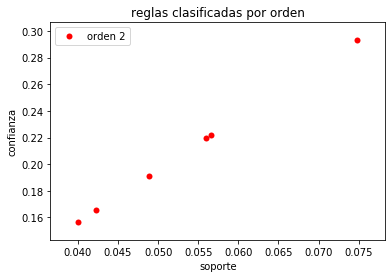

In [22]:
antecedent= primera_Reglas['antecedents'].value_counts().idxmax()
reglas_ant_1=contains_antecessor(primera_Reglas,list(antecedent))
print('reglas con antecedente sobre el total: '+str(len(reglas_ant_1)*100/len(primera_Reglas)))
display(reglas_ant_1)
plot_rules_no2(reglas_ant_1)

Como podemos observar, las reglas que surguen teniendo a <b>'whole milk'</b> como antecendente representan cerca del 30% del total de las reglas, sin embargo la mayoria de ellas tienen una confianza menor al 25%

### Segunda Configuración
Soporte minimo: 0.01047

In [23]:
segunda_Reglas = a_rules_by_confidence(segunda_Configuracion,0.0)
display(segunda_Reglas)

,antecedents,consequents,antecedent support,consequent support,support,confidence,order
0,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,2
1,(other vegetables),(beef),0.193493,0.052466,0.019725,0.101944,2
2,(beef),(rolls/buns),0.052466,0.183935,0.013625,0.259690,2
3,(rolls/buns),(beef),0.183935,0.052466,0.013625,0.074074,2
4,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,2
5,(root vegetables),(beef),0.108998,0.052466,0.017387,0.159515,2
6,(beef),(whole milk),0.052466,0.255516,0.021251,0.405039,2
7,(whole milk),(beef),0.255516,0.052466,0.021251,0.083168,2
8,(beef),(yogurt),0.052466,0.139502,0.011693,0.222868,2
9,(yogurt),(beef),0.139502,0.052466,0.011693,0.083819,2


Para esta configuracíon de soporte, se obtienen 545 reglas (sin contar con un umbral minimo de confianza)

#### Revisíon de reglas de asociación con antecedente

reglas con antecedente sobre el total: 19.5970695970696


,antecedents,consequents,antecedent support,consequent support,support,confidence,order
7,(whole milk),(beef),0.255516,0.052466,0.021251,0.083168,2
10,(whole milk),(berries),0.255516,0.033249,0.011795,0.046160,2
22,(whole milk),(bottled beer),0.255516,0.080529,0.020437,0.079984,2
46,(whole milk),(bottled water),0.255516,0.110524,0.034367,0.134501,2
61,(whole milk),(brown bread),0.255516,0.064870,0.025216,0.098687,2
71,(whole milk),(butter),0.255516,0.055414,0.027555,0.107839,2
75,(whole milk),(butter milk),0.255516,0.027961,0.011591,0.045364,2
86,(whole milk),(chicken),0.255516,0.042908,0.017590,0.068842,2
95,(whole milk),(chocolate),0.255516,0.049619,0.016675,0.065261,2
113,(whole milk),(citrus fruit),0.255516,0.082766,0.030503,0.119379,2


3


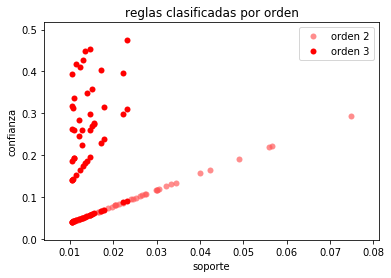

In [24]:
antecedent= segunda_Reglas['antecedents'].value_counts().idxmax()
reglas_ant_2=contains_antecessor(segunda_Reglas,list(antecedent))
print('reglas con antecedente sobre el total: '+str(len(reglas_ant_2)*100/len(segunda_Reglas)))
display(reglas_ant_2)
plot_rules_no2(reglas_ant_2)

Como podemos observar, las reglas que surguen teniendo a <b>'whole milk'</b> como antecendente representan cerca del 20% del total de las reglas, sin embargo todas ellas tienen una confianza menor al 50%

### Tercera Configuración
Soporte minimo: 0.00769

In [25]:
tercera_Reglas = a_rules_by_confidence(tercera_Configuracion,0.0)
display(tercera_Reglas)

,antecedents,consequents,antecedent support,consequent support,support,confidence,order
0,(UHT-milk),(other vegetables),0.033452,0.193493,0.008134,0.243161,2
1,(other vegetables),(UHT-milk),0.193493,0.033452,0.008134,0.042039,2
2,(baking powder),(whole milk),0.017692,0.255516,0.009253,0.522989,2
3,(whole milk),(baking powder),0.255516,0.017692,0.009253,0.036212,2
4,(beef),(citrus fruit),0.052466,0.082766,0.008439,0.160853,2
5,(citrus fruit),(beef),0.082766,0.052466,0.008439,0.101966,2
6,(beef),(other vegetables),0.052466,0.193493,0.019725,0.375969,2
7,(other vegetables),(beef),0.193493,0.052466,0.019725,0.101944,2
8,(beef),(rolls/buns),0.052466,0.183935,0.013625,0.259690,2
9,(rolls/buns),(beef),0.183935,0.052466,0.013625,0.074074,2


Para esta configuracíon de soporte, se obtienen 1162 reglas (sin contar con un umbral minimo de confianza)

#### Revisíon de reglas de asociación con antecedente

reglas con antecedente sobre el total: 20.567986230636834


,antecedents,consequents,antecedent support,consequent support,support,confidence,order
3,(whole milk),(baking powder),0.255516,0.017692,0.009253,0.036212,2
15,(whole milk),(beef),0.255516,0.052466,0.021251,0.083168,2
22,(whole milk),(berries),0.255516,0.033249,0.011795,0.046160,2
40,(whole milk),(bottled beer),0.255516,0.080529,0.020437,0.079984,2
82,(whole milk),(bottled water),0.255516,0.110524,0.034367,0.134501,2
107,(whole milk),(brown bread),0.255516,0.064870,0.025216,0.098687,2
131,(whole milk),(butter),0.255516,0.055414,0.027555,0.107839,2
137,(whole milk),(butter milk),0.255516,0.027961,0.011591,0.045364,2
143,(whole milk),(candy),0.255516,0.029893,0.008236,0.032232,2
153,(whole milk),(canned beer),0.255516,0.077682,0.008846,0.034620,2


4


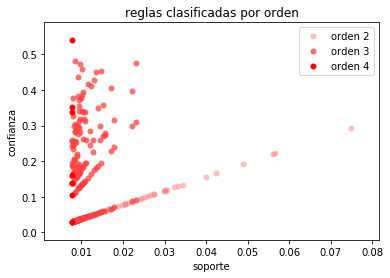

In [26]:
antecedent= tercera_Reglas['antecedents'].value_counts().idxmax()
reglas_ant_3=contains_antecessor(tercera_Reglas,list(antecedent))
print('reglas con antecedente sobre el total: '+str(len(reglas_ant_3)*100/len(tercera_Reglas)))
display(reglas_ant_3)
plot_rules_no2(reglas_ant_3)

Como podemos observar, las reglas que surguen teniendo a <b>'whole milk'</b> como antecendente representan cerca del 21% del total de las reglas, sin embargo la gran mayoria de ellas tienen una confianza menor al 50%

### Representación de Reglas
Utilizamos la <b>representación n° 2</b>, y ubicamos las graficas de las tres configuraciónes de tal forma que podemos compararlas

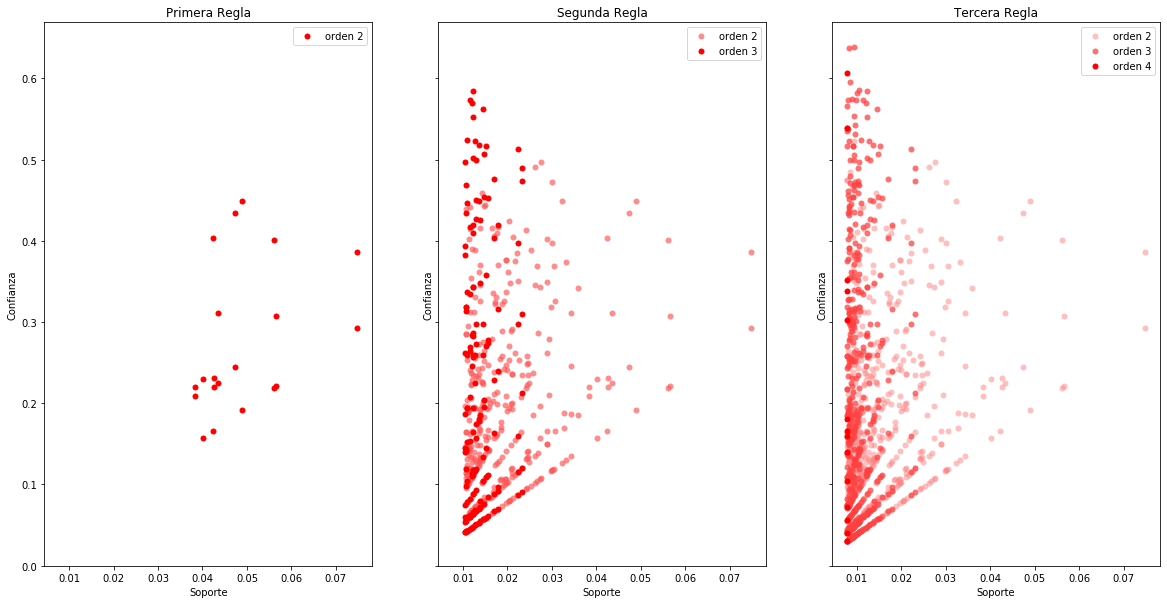

In [27]:
plot_rules_no2_3(primera_Reglas, segunda_Reglas, tercera_Reglas)

En las gráficas superiores, se muestran los elementos dados para cada regla según su confianza y soporte, ordenadas de mayor a menor soporte mínimo. Por ello, es muy razonable que a medida que avanzamos en las gráficas hay cada vez más elementos, pues vamos minimizando el soporte mínimo.

Los soportes mínimos para las gráficas son: 0.03807, 0.01047 y 0.00769.

Hay que decir que no se ha especificado una confianza mínima por lo que aparecerán absolutamente todos los items por encima de nuetro soporte, sin ninguna restricción más.

Asimismo, a medida que relajamos el soporte aparecen reglas de mayor orden, es decir, reglas que contienen mayor número de items, independientemente de si son sucesores o antecesores. 

### Representación grafica n° 2 (grafos)

Primero estableceremos las reglas a usar para crear el grafo, puesto que las actuales no cuentan con un umbral minimo de confianza.

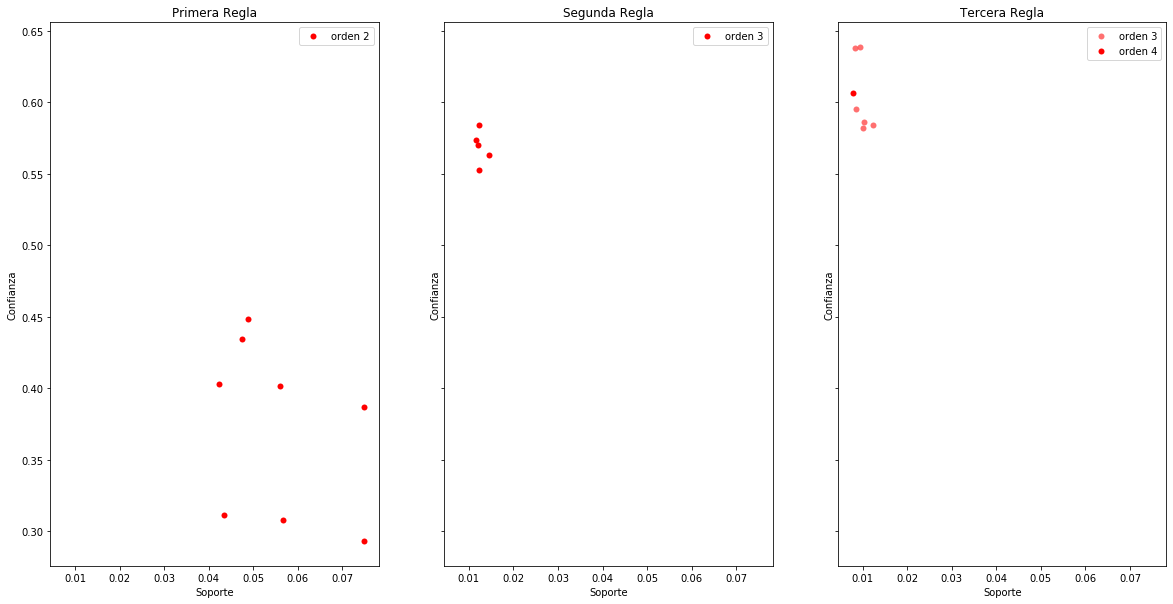

In [28]:
primera_Reglas = a_rules_by_confidence(primera_Configuracion,0.25)
segunda_Reglas = a_rules_by_confidence(segunda_Configuracion,0.53)
tercera_Reglas = a_rules_by_confidence(tercera_Configuracion,0.58)
plot_rules_no2_3(primera_Reglas, segunda_Reglas, tercera_Reglas)

En las reglas anteriores, asignamos una confianza mínima a las reglas de forma que, como se puede observar, el número de elementos en cada regla se ve reducido enormemente.

Las confianzas mínimas establecidas han sido 0.25, 0.53 y 0.58. De esta forma, a medida que vamos aumentando la confianza mínima, el número de elementos se reduce. Se puede observar que en las reglas 2 y 3, los elementos son de orden 3 y 4  aunque su probabilidad de aparición (soporte) es menor.

A partir de aquí, se puede proceder a la creación de los grafos.

## Grafos

La información que la grafica representa es la siguiente:
<ul>
    <li>Reglas de asociación: nodos grises</li>
    <li>Items: nodos blancos</li>
    <li>Antecedentes:representados por las aristas azules</li>
    <li>Consecuentes: representados por las aristas verdes</li>
    <li>Confianza: representada por la intensidad de las aristas</li>
    </ul>
<b> Nota:</b> <br> 
Hay que tener en cuenta que las aristas azules son antecedentes y las aristas verdes son consecuentes.

### Primera Configuración

//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


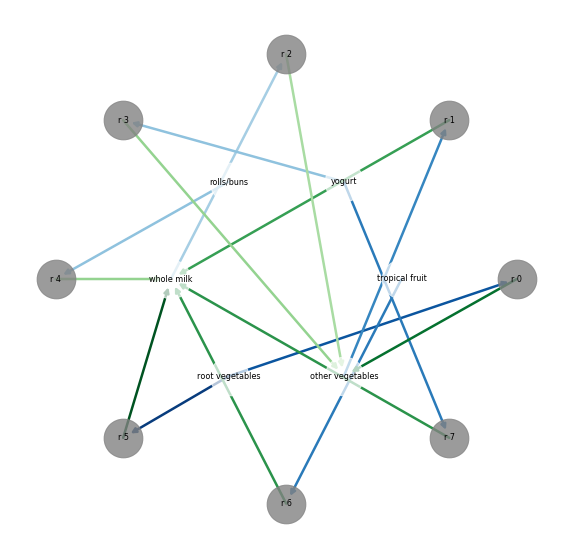

In [29]:
plot_rules_no1(primera_Reglas)

Para una configuración de soporte igual a 0.03807 y confianza mínima de 0.25, las reglas más destacables, por lo menos en confianza, son las siguientes:
<ul>
    <li>(root vegetables)$\rightarrow$ (whole milk)</li>
    <li>(whole milk)$\rightarrow$ (other vegetables)</li>
</ul>
   
De forma general, casi todas las reglas de la configuración están relacionadas con 'whole milk'. Todos estas reglas son de orden 2, por lo que sólo habrá un antecesor y sucesor. 

### Segunda Configuración

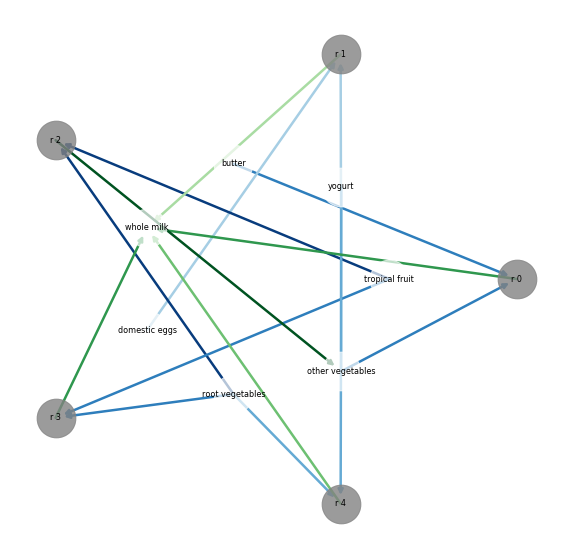

In [30]:
plot_rules_no1(segunda_Reglas)

Para una configuración de soporte igual a 0.01047 y confianza mínima de 0.53, las reglas mas destacables, por lo menos en confianza, son las siguientes:
<ul>
    <li>(tropical fruit, root vegetables)$\rightarrow$ (other vegetables)</li>
    <li>(other vegetables, butter)$\rightarrow$ (whole milk)</li>
    <li>(tropical fruit, root vegetables)$\rightarrow$ (whole milk)</li>
</ul>

De forma curiosa, todas las reglas excepto una, tiene como sucesora a leche entera. Asimismo, cuando se compra fruta tropical y tubérculos, también suelen comprarse otros vegetales, esto podría ser debido a cuestiones vegetarianas o veganas.

### Tercera Configuración

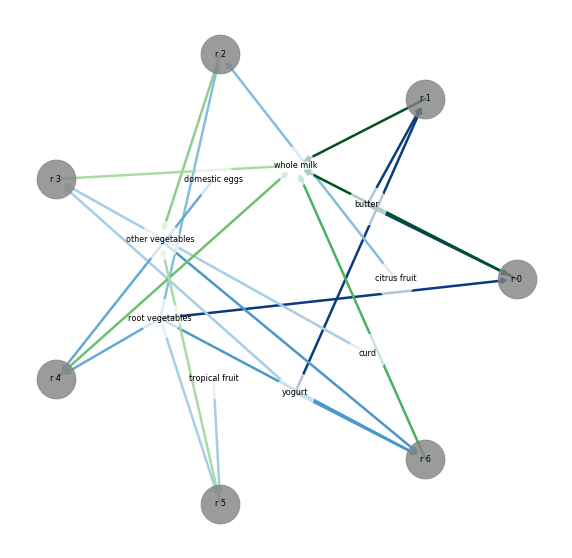

In [31]:
plot_rules_no1(tercera_Reglas)

Para una configuración de soporte igual a 0.00769 y confianza mínima de 0.58, las reglas mas destacables, por lo menos en confianza, son las siguientes:
<ul>
    <li>(tropical fruit, root vegetables)$\rightarrow$ (other vegetables)</li>
    <li>(yogurt, butter)$\rightarrow$ (whole milk)</li>
</ul>

De nuevo, la gran mayoría de las reglas están relacionadas con la leche entera y además, de forma genérica es sucesora. 

En cuanto a lo más destacable, cuando se compra yogurt y mantequilla suele comprarse también leche entera. Todos estos productos son lácteos, por lo que se podría pensar que se realiza la compra para cocinar una tarta o algún postre.

## Conclusiones

Como se han visto en todos estas configuraciones de grafos, viendo los antecesores y sucesores de las reglas, podemos decir que el elemento más sucesor es la leche entera, esto tiene sentido dado que es el elemento k = 1 con mayor frecuencia de soporte y, por lo tanto, tendrá mayores probabilidades de aparecer.

# Dataset Cáncer de mama
En este dataset, se encuentran las siguientes columnas:
<ul>
    <li><i><b>Class:</b></i> Clase (si ha sido recurrente o no recurrente el evento)</li>
    <li><i><b>Age:</b></i> Edad de la persona afectada (casos entre los 10 y 99 años, en intervalos iguales de 10 años)</li>
    <li><i><b>Menopause:</b></i>Edad en que ocurrió la menopausia de la paciente
        <ul>
            <li><b>lt40:</b> Despues de los 40 años</li>
            <li><b>ge40:</b> Antes de los 40 años</li>
            <li><b>premeno:</b> Se encuentra en condición premenopausica</li>
        </ul></li>
    <li><i><b>Tumor size:</b></i> Tamaño del tumor (casos entre 0 y 59 mm en intervalos de 5 mm)</li>
    <li><i><b>Inv nodes:</b></i> Número de nódulos linfáticos comprometidos (casos de entre 0 y 39 nodulos en intervalos de 3 nodulos)</li>
    <li><i><b>Node-caps:</b></i> Presencia de células cancerosas que atravesaron la cápsula de los nódulos (si o no)</li>
    <li><i><b>Deg-malig:</b></i> Grado de malignidad</li>
    <li><i><b>Breast:</b></i> Pecho afectado</li>
    <li><i><b>Breast-quad:</b></i> Cuadrante del pecho afectado</li>
    <li><i><b>Irradiat:</b></i> Indica si la paciente recibió radioterapia</li>
</ul>
<i>Información obtenida de: <a href="http://www.fundacionsadosky.org.ar/pcd-salud/analisis_exploratorio.html">Análisis exploratorio de Marcelo Soria (Fundación sadosky)</a></i>

## Creación del DataFrame

In [32]:
#Cargamos el dataset con los datos del archivo cancer.csv e insertando el nombre de las columnas almacenado en cancer.txt.
#Guardamos el dataset cancer.csv en un numpy array. 
with open('Lab2Recursos/Datos/CancerPecho/cancer.csv', newline='') as csvfile:
    datos_cancer = list(csv.reader(csvfile))

#Guardamos las etiquetas que se nos dan en el archivo cancer.txt como columnas del dataframe df_cancer_etiquetados que
#se corresponde con el dataframe de la lista datos_cancer. 
df_cancer_etiquetados = pd.DataFrame(datos_cancer) 
df_cancer_etiquetados.columns = ["Class", "age", "menopause", "tumor-size", "inv-nodes",
                                 "node-caps", "deg-malig", "breast", "breast-quad", 
                                "irradiat"]   

#Para facilitar la comprensión de los valores de las variables "no" y "yes", sustituimos dichos valores por sinónimos más
#significativos: "irradiated", "no-irradiated", "yes-nodecaps" y "no-nodecaps".
df_cancer_etiquetados["irradiat"] = df_cancer_etiquetados["irradiat"].replace("yes", "irradiated")
df_cancer_etiquetados["irradiat"] = df_cancer_etiquetados["irradiat"].replace("no", "no-irradiated")

df_cancer_etiquetados["node-caps"] = df_cancer_etiquetados["node-caps"].replace("yes", "yes-nodecaps")
df_cancer_etiquetados["node-caps"] = df_cancer_etiquetados["node-caps"].replace("no", "no-nodecaps")
print(len(df_cancer_etiquetados))
display(df_cancer_etiquetados.head())

286


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no-nodecaps,3,left,left_low,no-irradiated
1,no-recurrence-events,40-49,premeno,20-24,0-2,no-nodecaps,2,right,right_up,no-irradiated
2,no-recurrence-events,40-49,premeno,20-24,0-2,no-nodecaps,2,left,left_low,no-irradiated
3,no-recurrence-events,60-69,ge40,15-19,0-2,no-nodecaps,2,right,left_up,no-irradiated
4,no-recurrence-events,40-49,premeno,0-4,0-2,no-nodecaps,2,right,right_low,no-irradiated


In [33]:
mask = np.column_stack([df_cancer_etiquetados[col].str.contains(r"\?", na=False) for col in df_cancer_etiquetados])
missings=df_cancer_etiquetados.loc[mask.any(axis=1)]
display(missings)
dropind=missings.index

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
145,no-recurrence-events,40-49,premeno,25-29,0-2,?,2,left,right_low,irradiated
163,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_up,irradiated
164,no-recurrence-events,60-69,ge40,25-29,3-5,?,1,right,left_low,irradiated
183,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_up,irradiated
184,no-recurrence-events,50-59,ge40,30-34,9-11,?,3,left,left_low,irradiated
206,recurrence-events,50-59,ge40,30-34,0-2,no-nodecaps,3,left,?,no-irradiated
233,recurrence-events,70-79,ge40,15-19,9-11,?,1,left,left_low,irradiated
263,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_up,no-irradiated
264,recurrence-events,50-59,lt40,20-24,0-2,?,1,left,left_low,no-irradiated


In [34]:
df_cancer_etiquetados.dropna(inplace=True)
df_cancer_etiquetados.drop(dropind,inplace=True)
print(len(df_cancer_etiquetados))

277


## Itemsets frecuentes para k = 1

In [35]:
#Obtenermos los itemset frecuentes para k=1. Obtenemos también el soporte de los itemset.
#Para ello, necesitamos transformarlo al formato válido. 
df_cancer = encoder(df_cancer_etiquetados.values.tolist())
display(df_cancer.head())
itemsets_cancer_k1 = get_all_k1_itemsets(df_cancer)

,0-2,0-4,1,10-14,12-14,15-17,15-19,2,20-24,20-29,...,lt40,no-irradiated,no-nodecaps,no-recurrence-events,premeno,recurrence-events,right,right_low,right_up,yes-nodecaps
0,True,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,False,False,False,False,False
1,True,False,False,False,False,False,False,True,True,False,...,False,True,True,True,True,False,True,False,True,False
2,True,False,False,False,False,False,False,True,True,False,...,False,True,True,True,True,False,False,False,False,False
3,True,False,False,False,False,False,True,True,False,False,...,False,True,True,True,False,False,True,False,False,False
4,True,True,False,False,False,False,False,True,False,False,...,False,True,True,True,True,False,True,True,False,False


## Itemsets frecuentes para k > 1

In [36]:
#Análisis de configuraciones de soporte:
#Repetimos el proceso hasta que no se generen nuevos itemsets frecuentes.
desc=itemsets_cancer_k1.describe()
qt=itemsets_cancer_k1.quantile([.8, .7,.6])
display(desc)
sp1=qt.support[0.8]
sp2=qt.support[0.7]
sp3=qt.support[0.6]
print('Primera configuración= frecuencia de soporte: {0:.0f} soporte: {1:.5f}'.format(len(compras_tr.index)*sp1,sp1))
print('Segunda configuración= frecuencia de soporte: {0:.0f} soporte: {1:.5f}'.format(len(compras_tr.index)*sp2,sp2))
print('Tercera configuración= frecuencia de soporte: {0:.0f} soporte: {1:.5f}'.format(len(compras_tr.index)*sp3,sp3))

,support
count,43.000000
mean,0.232558
std,0.230209
min,0.003610
25%,0.045126
50%,0.173285
75%,0.333935
max,0.797834


Primera configuración= frecuencia de soporte: 4126 soporte: 0.41949
Segunda configuración= frecuencia de soporte: 3011 soporte: 0.30614
Tercera configuración= frecuencia de soporte: 2059 soporte: 0.20939


### Primera Configuración

In [37]:
#Para soporte = 0.52937 obtenido tras el análisis de configuraciones de soporte.
it_frecuentes_sp1=get_freq_itemsets(df_cancer,sp1)
n=it_frecuentes_sp1['length'].max()
for i in range(1,n+1):
    print('\n\nXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K={} XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n'.format(i))
    display(get_k_th_frecuent_itemsets(df_cancer,sp1,i))



XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=1 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
0,0.754513,(0-2),1
1,0.465704,(2),1
2,0.444043,(ge40),1
3,0.523466,(left),1
4,0.776173,(no-irradiated),1
5,0.797834,(no-nodecaps),1
6,0.707581,(no-recurrence-events),1
7,0.537906,(premeno),1
8,0.476534,(right),1




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=2 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
9,0.649819,"(no-irradiated, 0-2)",2
10,0.722022,"(0-2, no-nodecaps)",2
11,0.599278,"(no-recurrence-events, 0-2)",2
12,0.675090,"(no-irradiated, no-nodecaps)",2
13,0.592058,"(no-irradiated, no-recurrence-events)",2
14,0.617329,"(no-recurrence-events, no-nodecaps)",2
15,0.422383,"(premeno, no-nodecaps)",2




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=3 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
16,0.635379,"(no-irradiated, 0-2, no-nodecaps)",3
17,0.530686,"(no-irradiated, no-recurrence-events, 0-2)",3
18,0.577617,"(no-recurrence-events, 0-2, no-nodecaps)",3
19,0.545126,"(no-irradiated, no-recurrence-events, no-nodec...",3




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=4 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
20,0.523466,"(no-irradiated, no-recurrence-events, 0-2, no-...",4


### Segunda Configuración

In [38]:
#Para soporte = 0.41119 obtenido tras el análisis de configuraciones de soporte.
it_frecuentes_sp2=get_freq_itemsets(df_cancer,sp2)
n=it_frecuentes_sp2['length'].max()
for i in range(1,n+1):
    print('\n\nXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K={} XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n'.format(i))
    display(get_k_th_frecuent_itemsets(df_cancer,sp2,i))



XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=1 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
0,0.754513,(0-2),1
1,0.465704,(2),1
2,0.321300,(40-49),1
3,0.328520,(50-59),1
4,0.444043,(ge40),1
5,0.523466,(left),1
6,0.382671,(left_low),1
7,0.339350,(left_up),1
8,0.776173,(no-irradiated),1
9,0.797834,(no-nodecaps),1




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=2 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
13,0.350181,"(2, 0-2)",2
14,0.335740,"(0-2, ge40)",2
15,0.400722,"(0-2, left)",2
16,0.649819,"(no-irradiated, 0-2)",2
17,0.722022,"(0-2, no-nodecaps)",2
18,0.599278,"(no-recurrence-events, 0-2)",2
19,0.400722,"(0-2, premeno)",2
20,0.353791,"(0-2, right)",2
21,0.353791,"(no-irradiated, 2)",2
22,0.371841,"(2, no-nodecaps)",2




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=3 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
40,0.332130,"(2, 0-2, no-nodecaps)",3
41,0.324910,"(0-2, ge40, no-nodecaps)",3
42,0.353791,"(no-irradiated, 0-2, left)",3
43,0.393502,"(0-2, left, no-nodecaps)",3
44,0.328520,"(no-recurrence-events, 0-2, left)",3
45,0.635379,"(no-irradiated, 0-2, no-nodecaps)",3
46,0.530686,"(no-irradiated, no-recurrence-events, 0-2)",3
47,0.335740,"(no-irradiated, 0-2, premeno)",3
48,0.577617,"(no-recurrence-events, 0-2, no-nodecaps)",3
49,0.379061,"(0-2, premeno, no-nodecaps)",3




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=4 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
60,0.350181,"(no-irradiated, 0-2, left, no-nodecaps)",4
61,0.321300,"(no-recurrence-events, 0-2, left, no-nodecaps)",4
62,0.523466,"(no-irradiated, no-recurrence-events, 0-2, no-...",4
63,0.324910,"(no-irradiated, 0-2, premeno, no-nodecaps)",4


### Tercera Configuración

In [39]:
#Para soporte = 0.20769 obtenido tras el análisis de configuraciones de soporte.
it_frecuentes_sp3=get_freq_itemsets(df_cancer,sp3)
n=it_frecuentes_sp3['length'].max()
for i in range(1,n+1):
    print('\n\nXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K={} XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX\n'.format(i))
    display(get_k_th_frecuent_itemsets(df_cancer,sp3,i))



XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=1 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
0,0.754513,(0-2),1
1,0.238267,(1),1
2,0.465704,(2),1
3,0.296029,(3),1
4,0.321300,(40-49),1
5,0.328520,(50-59),1
6,0.444043,(ge40),1
7,0.223827,(irradiated),1
8,0.523466,(left),1
9,0.382671,(left_low),1




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=2 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
17,0.234657,"(1, 0-2)",2
18,0.350181,"(2, 0-2)",2
19,0.241877,"(0-2, 40-49)",2
20,0.245487,"(0-2, 50-59)",2
21,0.335740,"(0-2, ge40)",2
22,0.400722,"(0-2, left)",2
23,0.281588,"(left_low, 0-2)",2
24,0.259928,"(0-2, left_up)",2
25,0.649819,"(no-irradiated, 0-2)",2
26,0.722022,"(0-2, no-nodecaps)",2




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=3 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
72,0.220217,"(1, 0-2, no-irradiated)",3
73,0.234657,"(1, 0-2, no-nodecaps)",3
74,0.296029,"(no-irradiated, 2, 0-2)",3
75,0.332130,"(2, 0-2, no-nodecaps)",3
76,0.288809,"(2, no-recurrence-events, 0-2)",3
77,0.227437,"(0-2, 40-49, no-nodecaps)",3
78,0.223827,"(0-2, premeno, 40-49)",3
79,0.231047,"(no-irradiated, 0-2, 50-59)",3
80,0.231047,"(0-2, 50-59, no-nodecaps)",3
81,0.209386,"(no-recurrence-events, 0-2, 50-59)",3




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=4 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
134,0.220217,"(1, 0-2, no-irradiated, no-nodecaps)",4
135,0.288809,"(no-irradiated, 2, 0-2, no-nodecaps)",4
136,0.245487,"(no-irradiated, no-recurrence-events, 0-2, 2)",4
137,0.274368,"(2, no-recurrence-events, 0-2, no-nodecaps)",4
138,0.209386,"(0-2, premeno, 40-49, no-nodecaps)",4
139,0.223827,"(no-irradiated, 0-2, 50-59, no-nodecaps)",4
140,0.292419,"(no-irradiated, 0-2, ge40, no-nodecaps)",4
141,0.259928,"(no-irradiated, no-recurrence-events, 0-2, ge40)",4
142,0.277978,"(no-recurrence-events, 0-2, ge40, no-nodecaps)",4
143,0.350181,"(no-irradiated, 0-2, left, no-nodecaps)",4




XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX K=5 XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



,support,itemsets,length
161,0.238267,"(no-irradiated, no-nodecaps, 2, no-recurrence-...",5
162,0.256318,"(no-irradiated, no-nodecaps, no-recurrence-eve...",5
163,0.292419,"(no-irradiated, no-nodecaps, no-recurrence-eve...",5
164,0.249097,"(no-irradiated, no-nodecaps, no-recurrence-eve...",5
165,0.231047,"(no-irradiated, right, no-nodecaps, no-recurre...",5


In [40]:
#Mostramos todas las reglas con la confianza de cada una de ellas.
#Para el primer soporte: 
reglas_sp1=a_rules_by_confidence(it_frecuentes_sp1, 0.0)
print("\n--------------------------REGLAS PARA EL PRIMER SOPORTE-----------------------------\n")
display(reglas_sp1)



--------------------------REGLAS PARA EL PRIMER SOPORTE-----------------------------



,antecedents,consequents,antecedent support,consequent support,support,confidence,order
0,(no-irradiated),(0-2),0.776173,0.754513,0.649819,0.837209,2
1,(0-2),(no-irradiated),0.754513,0.776173,0.649819,0.861244,2
2,(0-2),(no-nodecaps),0.754513,0.797834,0.722022,0.956938,2
3,(no-nodecaps),(0-2),0.797834,0.754513,0.722022,0.904977,2
4,(no-recurrence-events),(0-2),0.707581,0.754513,0.599278,0.846939,2
5,(0-2),(no-recurrence-events),0.754513,0.707581,0.599278,0.794258,2
6,(no-irradiated),(no-nodecaps),0.776173,0.797834,0.675090,0.869767,2
7,(no-nodecaps),(no-irradiated),0.797834,0.776173,0.675090,0.846154,2
8,(no-irradiated),(no-recurrence-events),0.776173,0.707581,0.592058,0.762791,2
9,(no-recurrence-events),(no-irradiated),0.707581,0.776173,0.592058,0.836735,2


In [41]:
#Para el segundo soporte:
reglas_sp2=a_rules_by_confidence(it_frecuentes_sp2, 0.0)
print("\n--------------------------REGLAS PARA EL SEGUNDO SOPORTE-----------------------------\n")
display(reglas_sp2)


--------------------------REGLAS PARA EL SEGUNDO SOPORTE-----------------------------



,antecedents,consequents,antecedent support,consequent support,support,confidence,order
0,(2),(0-2),0.465704,0.754513,0.350181,0.751938,2
1,(0-2),(2),0.754513,0.465704,0.350181,0.464115,2
2,(0-2),(ge40),0.754513,0.444043,0.335740,0.444976,2
3,(ge40),(0-2),0.444043,0.754513,0.335740,0.756098,2
4,(0-2),(left),0.754513,0.523466,0.400722,0.531100,2
5,(left),(0-2),0.523466,0.754513,0.400722,0.765517,2
6,(no-irradiated),(0-2),0.776173,0.754513,0.649819,0.837209,2
7,(0-2),(no-irradiated),0.754513,0.776173,0.649819,0.861244,2
8,(0-2),(no-nodecaps),0.754513,0.797834,0.722022,0.956938,2
9,(no-nodecaps),(0-2),0.797834,0.754513,0.722022,0.904977,2


In [42]:
#Para el tercer soporte: 
reglas_sp3=a_rules_by_confidence(it_frecuentes_sp3, 0.0)
print("\n--------------------------REGLAS PARA EL TERCER SOPORTE-----------------------------\n")
display(reglas_sp3)


--------------------------REGLAS PARA EL TERCER SOPORTE-----------------------------



,antecedents,consequents,antecedent support,consequent support,support,confidence,order
0,(1),(0-2),0.238267,0.754513,0.234657,0.984848,2
1,(0-2),(1),0.754513,0.238267,0.234657,0.311005,2
2,(2),(0-2),0.465704,0.754513,0.350181,0.751938,2
3,(0-2),(2),0.754513,0.465704,0.350181,0.464115,2
4,(0-2),(40-49),0.754513,0.321300,0.241877,0.320574,2
5,(40-49),(0-2),0.321300,0.754513,0.241877,0.752809,2
6,(0-2),(50-59),0.754513,0.328520,0.245487,0.325359,2
7,(50-59),(0-2),0.328520,0.754513,0.245487,0.747253,2
8,(0-2),(ge40),0.754513,0.444043,0.335740,0.444976,2
9,(ge40),(0-2),0.444043,0.754513,0.335740,0.756098,2


### Reglas de items frecuentes

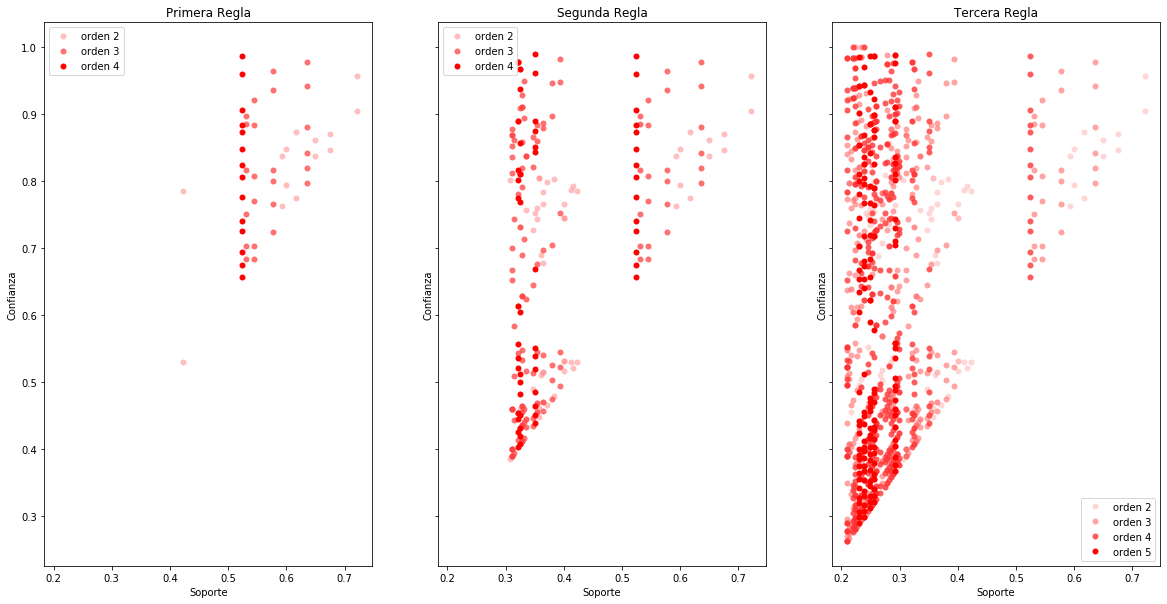

In [43]:
plot_rules_no2_3(reglas_sp1, reglas_sp2, reglas_sp3)

En las gráficas superiores, se muestran los elementos dados para cada regla según su confianza y soporte, ordenadas de mayor a menor soporte mínimo. Por ello, es muy razonable que a medida que avanzamos en las gráficas hay cada vez más elementos, pues vamos minimizando el soporte mínimo.

Los soportes mínimos para las gráficas son: 0.41119, 0.29895 y 0.20769.

Como se ha hecho anteriormente, no se ha especificado ningún tipo de confianza mínima con el objetivo de mostrar todos los datos posibles y más frecuentes.

Asimismo, a medida que relajamos el soporte aparecen reglas de mayor orden, es decir, reglas que contienen mayor número de items, independientemente de si son sucesores o antecesores.

### Reglas de alta confianza

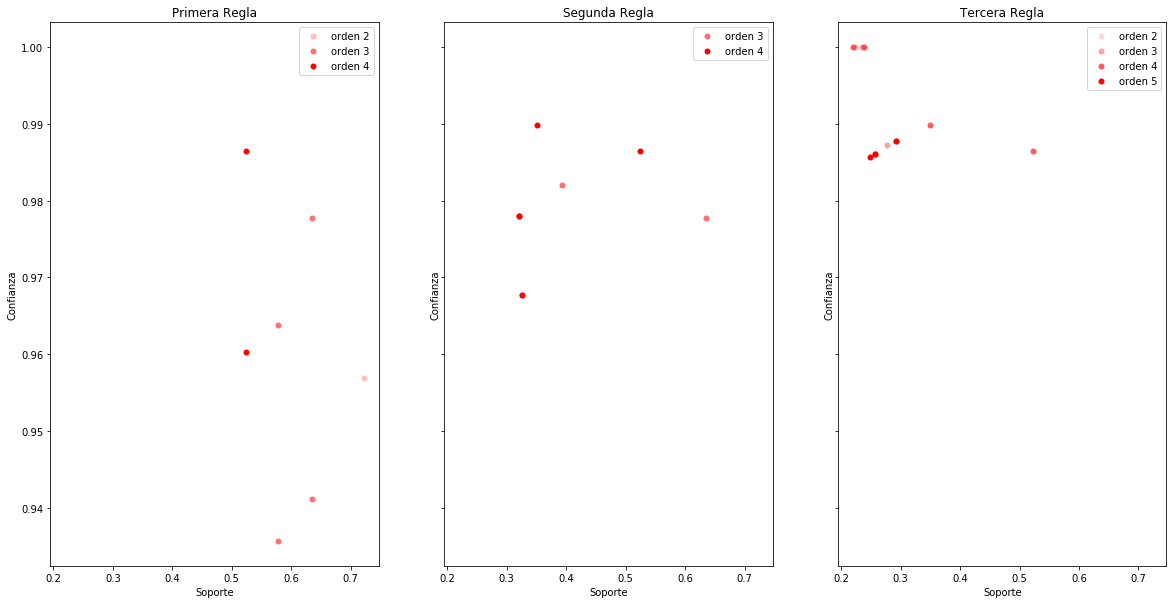

In [44]:
#Para el primer soporte: 
reglas_confianza_sp1=a_rules_by_confidence(it_frecuentes_sp1, 0.93)
#Para el segundo soporte:
reglas_confianza_sp2=a_rules_by_confidence(it_frecuentes_sp2, 0.965)
#Para el tercer soporte: 
reglas_confianza_sp3=a_rules_by_confidence(it_frecuentes_sp3, 0.985)
plot_rules_no2_3(reglas_confianza_sp1, reglas_confianza_sp2, reglas_confianza_sp3)

En las reglas anteriores, asignamos una confianza mínima a las reglas de forma que, como se puede observar, el número de elementos en cada regla se ve reducido enormemente.

Las confianzas mínimas establecidas han sido 0.93, 0.965 y 0.985. 

De esta forma, a medida que vamos aumentando la confianza mínima, el número de elementos se reduce. Se puede observar que en la regla 2 es de orden 3 y 4, mientras que en la regla 3 son de orden 4 y 5. Asimismo, a medida que vamos aumentando la confianza el soporte se va reduciendo.

A partir de aquí, se puede proceder a la creación de los grafos.

## Grafos
### Primera configuración

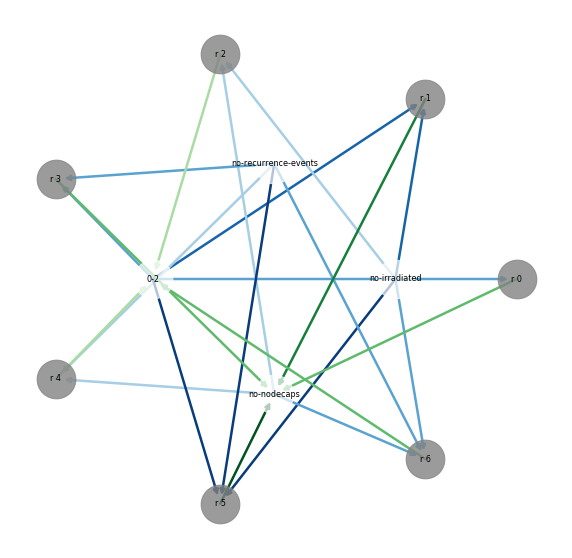

In [45]:
plot_rules_no1(reglas_confianza_sp1)

Para una configuración de soporte igual a 0.41119 y confianza mínima de 0.93, las reglas más destacables, por lo menos en confianza, son las siguientes:

<ul>
    <li>(no-irradiated, no-recurrence-events, 0-2)$\rightarrow$ (no-nodecaps)</li>
    <li>(no-irradiated, no-recurrence-events, no-nodecaps)$\rightarrow$ (0-2)</li>
</ul>

Una de las reglas que tiene mayor peso sería la regla número 5. Esta regla es bastante importante y predecible, ya que dice que cuando el paciente no recibe radioterapia, no es recurrente y además el número de nódulos linfáticos es mínimo, entonces no existe presencia de células cancerosas que hayan atravesado la cápsula de los nódulos.

### Segunda Configuración

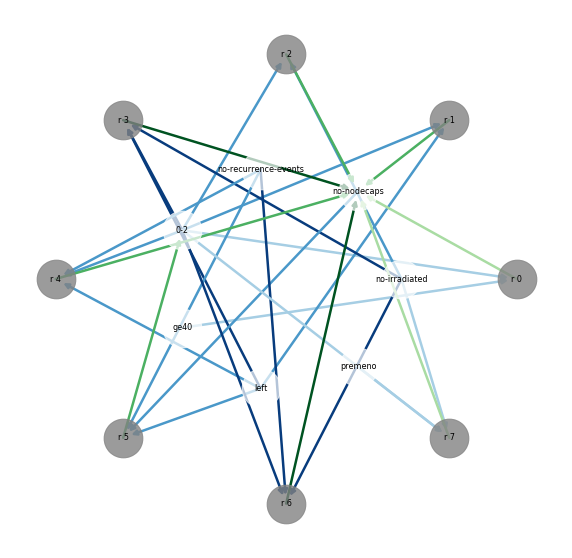

In [46]:
plot_rules_no1(reglas_confianza_sp2)

Para una configuración de soporte igual a 0.29895 y confianza mínima de 0.965, las reglas más destacables, por lo menos en confianza, son las siguientes:

<ul>
    <li>(no-irradiated, 0-2, left)$\rightarrow$ (no-nodecaps)</li>
    <li>(left, ge40)$\rightarrow$ (no-nodecaps)</li>
</ul>

En general, se puede observar que casi la totalidad de las reglas obtenidas tienen como sucesor a no-nodecaps.

Además, la regla número 3 especifica que cuando se da en el pecho izquierdo no suele haber presencia de células cancerígenas en la cápsula de nódulos.

Asimismo, la regla número 5 también especifica que cuando se da en el pecho izquierdo y la menopausia ocurre a una edad anterior a los 40 años, tampoco se da presencia de celulas cancerosas en la cápsula de nódulos. 

### Tercera Configuración

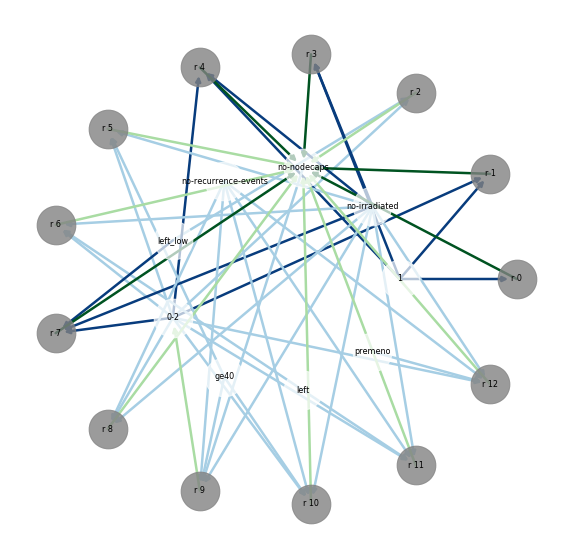

In [47]:
plot_rules_no1(reglas_confianza_sp3)

Para una configuración de soporte igual a 0.20769 y confianza mínima de 0.985, las reglas más destacables, por lo menos en confianza, son las siguientes:

<ul>
    <li>(no-irradiated, 0-2, 1)$\rightarrow$ (no-nodecaps)</li>
    <li>(left, 0-2, no-irradiated)$\rightarrow$ (no-nodecaps)</li>
</ul>

De nuevo, la gran mayoría de reglas tiene como sucesor a no-nodecaps. Esta vez, se especifíca un poco más con respecto a las anteriores configuraciones, y se dice que la parte baja del pecho izquierdo es la que más aparece como antecesora de no-nodecaps.